# Downloading accurate city location data

To do this, the Nominatim API will be used

In [1]:
import pandas as pd

data = pd.read_csv('PL_Miasta.csv')
data.head()

,Lokalizacja
0,Adamowo
1,Adolfowo
2,Aleksandrów Kujawski
3,Aleksandrów Łódzki
4,Alfonsów


In [12]:
from geopy.geocoders import Nominatim
import numpy as np

geolocator = Nominatim(user_agent="geoapiExercises")

def fetch_location_details(location):
    try:
        loc = geolocator.geocode(location + ", Poland")
        if loc:
            return loc.latitude, loc.longitude, loc.raw['display_name']
        else:
            return None, None, None
    except:
        return None, None, None

# test_locations = data['Lokalizacja'].head(5).apply(lambda x: fetch_location_details(x))
# test_locations

end_lis = []
for i in data['Lokalizacja']:
    temp = [i]
    temp.extend(fetch_location_details(i))
    end_lis.append(temp)
    df = pd.DataFrame(end_lis, columns=["name",'latitude','longitude','display_name'])
    df.to_excel('city_data2.xlsx', index=False)

### Custom function to systematize text data (divide into communes, counties and voivodeships)

In [13]:
df = pd.read_excel('city_data.xlsx')

def extract_info(row):
    parts = row['display_name'].split(',')
    gmina = None
    powiat = None
    wojewodztwo = None
    
    for part in parts:
        if 'gmina' in part:
            gmina = part.strip().split('gmina ')[-1].strip()
        elif 'powiat' in part:
            powiat = part.strip().split('powiat ')[-1].strip()
        elif 'województwo' in part:
            wojewodztwo = part.strip().split('województwo ')[-1].strip()
    
    return pd.Series([gmina, powiat, wojewodztwo])

df[['gmina', 'powiat', 'województwo']] = df.apply(extract_info, axis=1)
df.to_excel('city_data_Updated.xlsx', index=False)

The few missing data were filled in manually using Google search.
Then the obtained data were transferred to the final [file with data about advertisements from the OLX portal](Data_cleaned.xlsx).

# Text mining of ad titles on the OLX portal

### Data and model loading, vectorization and preliminary text mining.

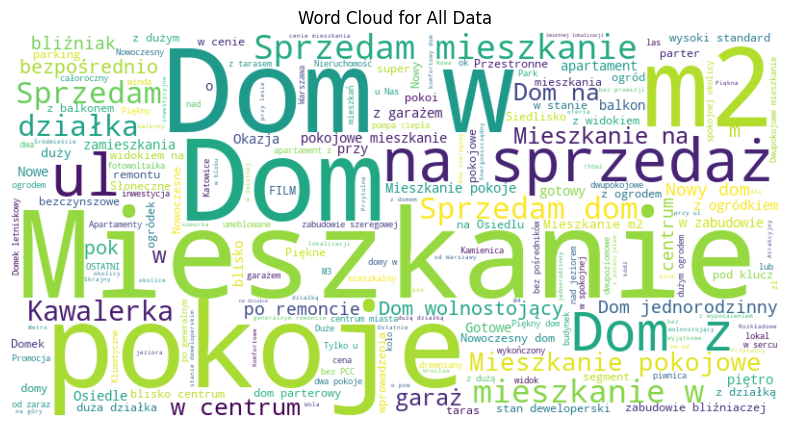

(2596, 3335)


In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from textblob import TextBlob
import pl_core_news_sm
from wordcloud import WordCloud
from scipy.sparse import csr_matrix

df = pd.read_excel('Data_cleaned.xlsx', usecols=['Title'])

def generate_wordcloud(data, title='Word Cloud'):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(str(data))
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title)
    plt.axis('off')
    plt.show()


all_text = ' '.join(df['Title'])
generate_wordcloud(all_text, 'Word Cloud for All Data')

nlp = pl_core_news_sm.load() # Polish NLP engine
stop_words = list(nlp.Defaults.stop_words)

vectorizer = TfidfVectorizer(stop_words=stop_words) # Text vectoring using the TF-IDF algorithm
tfidf_matrix = vectorizer.fit_transform(df['Title'])
print(tfidf_matrix.shape)

                                               Title  000  000zł   01   03  \
0  bezpośrednio 44 m + 20m poddasze ,nowe, wykońc...  0.0    0.0  0.0  0.0   
1                 Sprzedam mieszkanie w Opolu parter  0.0    0.0  0.0  0.0   
2  Sprzedam możliwość kupienia ostatniego wolnego...  0.0    0.0  0.0  0.0   
3  Kawalerka do wykończenia z niskim czynszem na ...  0.0    0.0  0.0  0.0   
4  Mieszkanie 131 m2 +garaż,  Gozdnica-Super inwe...  0.0    0.0  0.0  0.0   

   03m2   04   08   0s   10  ...  żyrardowie  żyrardów  żółkiewka  без  \
0   0.0  0.0  0.0  0.0  0.0  ...         0.0       0.0        0.0  0.0   
1   0.0  0.0  0.0  0.0  0.0  ...         0.0       0.0        0.0  0.0   
2   0.0  0.0  0.0  0.0  0.0  ...         0.0       0.0        0.0  0.0   
3   0.0  0.0  0.0  0.0  0.0  ...         0.0       0.0        0.0  0.0   
4   0.0  0.0  0.0  0.0  0.0  ...         0.0       0.0        0.0  0.0   

   будинок  города  дозволу  дом  купую  центре  
0      0.0     0.0      0.0  0.0    

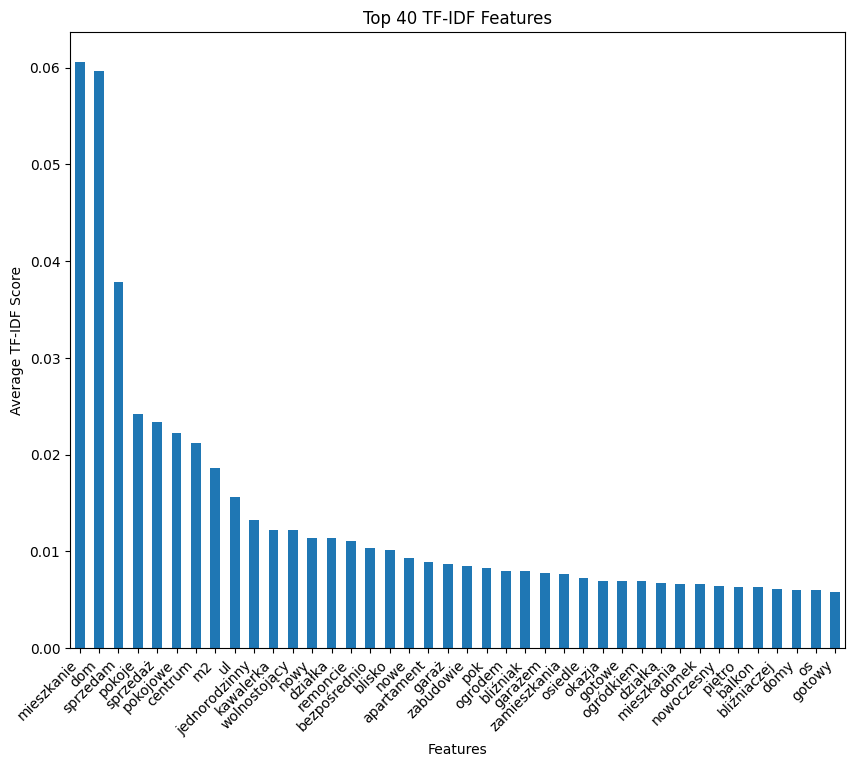

In [33]:
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out(), index=df.index)
combined_df = pd.concat([df, tfidf_df], axis=1)
print(combined_df.head())

mean_tfidf = tfidf_df.mean().sort_values(ascending=False)
# sum_tfidf = tfidf_df.sum().sort_values(ascending=False)
top_features = mean_tfidf.head(40)
print(top_features)

plt.figure(figsize=(10, 8))
top_features.plot(kind='bar')
plt.title('Top 40 TF-IDF Features')
plt.xlabel('Features')
plt.ylabel('Average TF-IDF Score')
plt.xticks(rotation=45, ha='right')
plt.show()

### Sentiment analysis.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at allegro/herbert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


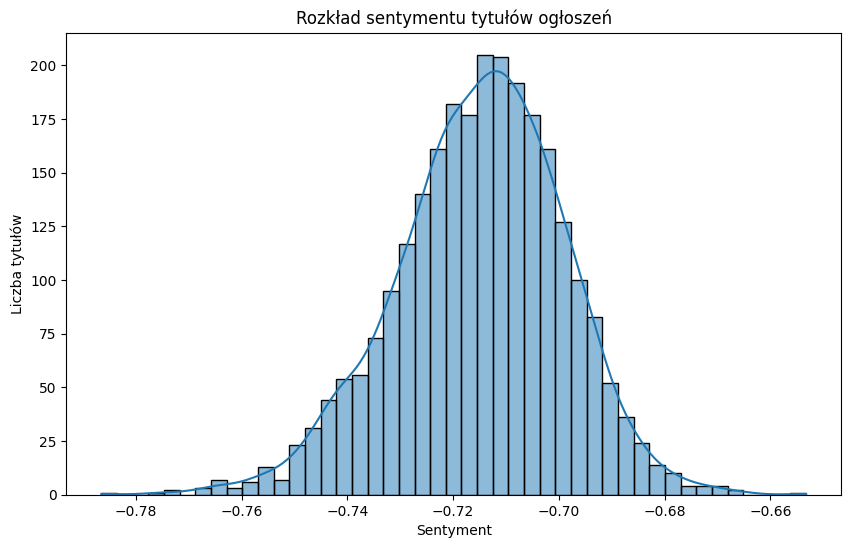

In [12]:
from transformers import pipeline

classifier = pipeline("sentiment-analysis", model="allegro/herbert-base-cased", framework="pt")

def get_sentiment(text):
    result = classifier(text)
    # We return the result as a number: -1 for negative, 0 for neutral, 1 for positive
    label = result[0]['label']
    score = result[0]['score']
    if label == 'LABEL_0':
        return -score  # Negative sentiment
    elif label == 'LABEL_1':
        return score  # Positive sentiment
    else:
        return 0 

df['sentiment'] = df['Title'].apply(get_sentiment)

plt.figure(figsize=(10, 6))
sns.histplot(df['sentiment'], kde=True)
plt.title('Rozkład sentymentu tytułów ogłoszeń')
plt.xlabel('Sentyment')
plt.ylabel('Liczba tytułów')
plt.show()

### PCA.

The purpose of PCA in this analysis is to select the number of clusters.

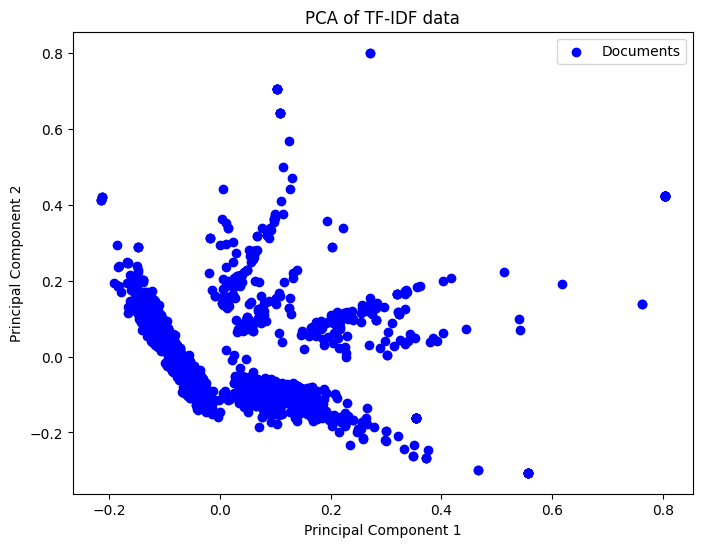

In [17]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
reduced_data = pca.fit_transform(tfidf_matrix.toarray())

plt.figure(figsize=(8, 6))
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c='blue', label='Documents')
plt.title('PCA of TF-IDF data')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()

4 Clusters were designated.

### Text clustering

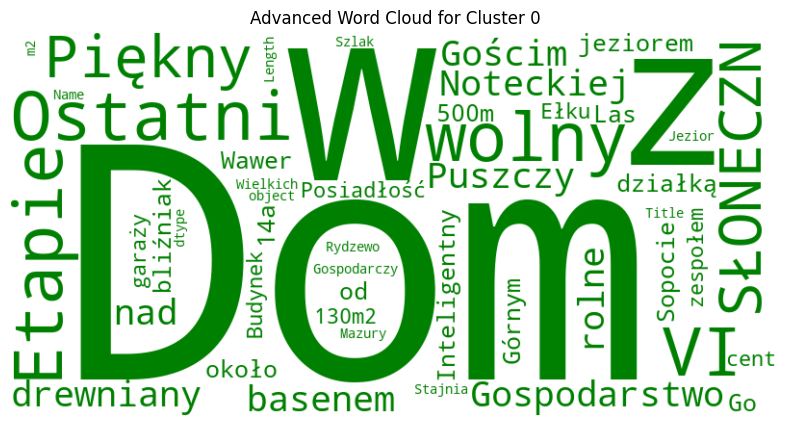

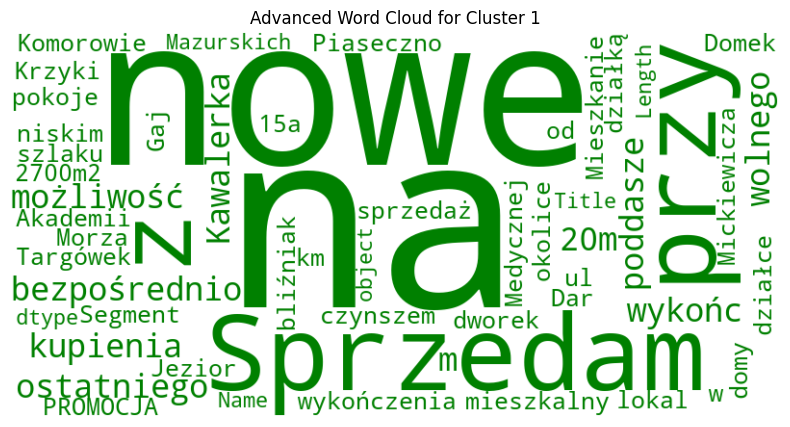

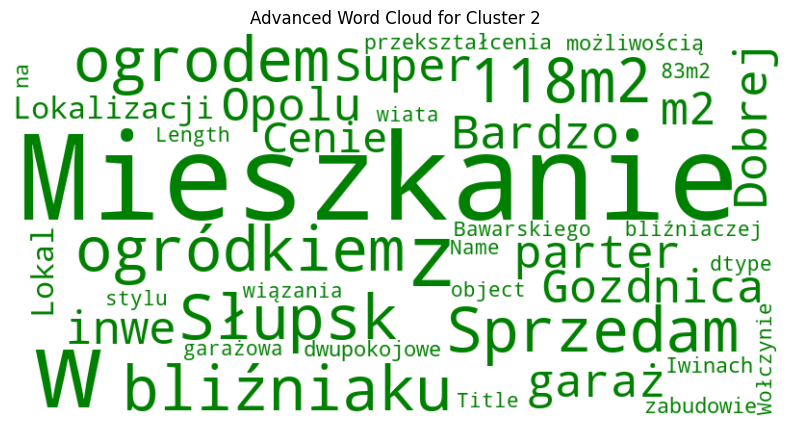

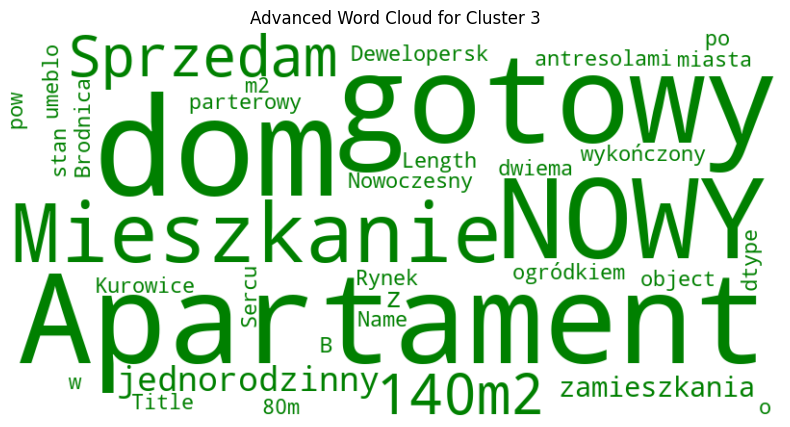

In [18]:
# Text clustering
n_clusters = 4
km_model = KMeans(n_clusters=n_clusters)
km_model.fit(tfidf_matrix)
df['cluster'] = km_model.labels_
df

def generate_advanced_wordcloud(data, title='Word Cloud'):
    # Preparing sentiment color mapping
    color_func = lambda *args, **kwargs: "red" if TextBlob(' '.join(args)).sentiment.polarity < 0 else "green"
    wordcloud = WordCloud(width=800, height=400, background_color ='white', color_func=color_func).generate(str(data))
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title)
    plt.axis('off')
    plt.show()

# Generating a word cloud with sentiment analysis for each group
for i in range(n_clusters):
    cluster_data = df[df['cluster'] == i]['Title']
    generate_advanced_wordcloud(cluster_data, f'Advanced Word Cloud for Cluster {i}')

Based on the word cloud analysis, the clusters were named:
0 - Titles focused on epithets.
1 - Informative, very descriptive ads.
2 - Extras (garden, garage, etc.)
3 - Condition of the apartment

### Results visualizations

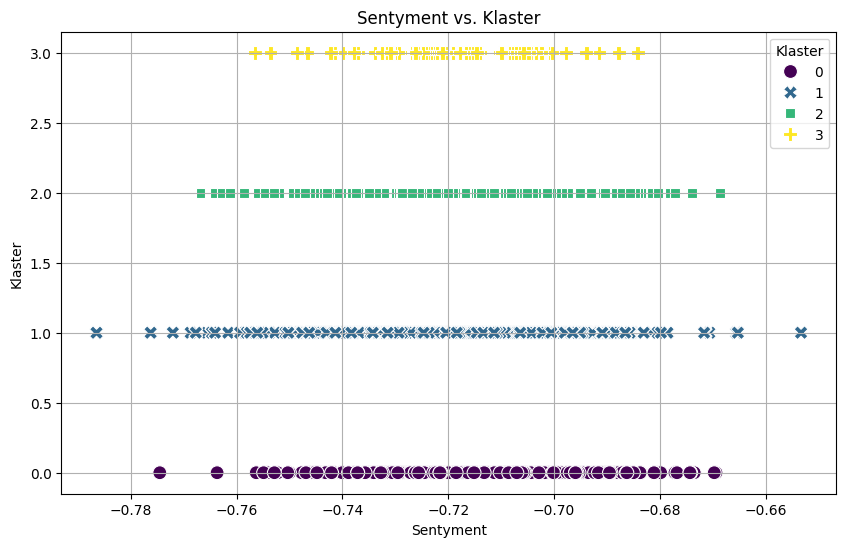

In [19]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='sentiment', y='cluster', palette='viridis', hue='cluster', style='cluster', s=100)
plt.title('Sentyment vs. Klaster')
plt.xlabel('Sentyment')
plt.ylabel('Klaster')
plt.legend(title='Klaster')
plt.grid(True)
plt.show()

/var/folders/04/fvr1lfzj0_d92z03bt_m1dvw0000gn/T/ipykernel_79923/3225369030.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='cluster', y='sentiment', palette='coolwarm')


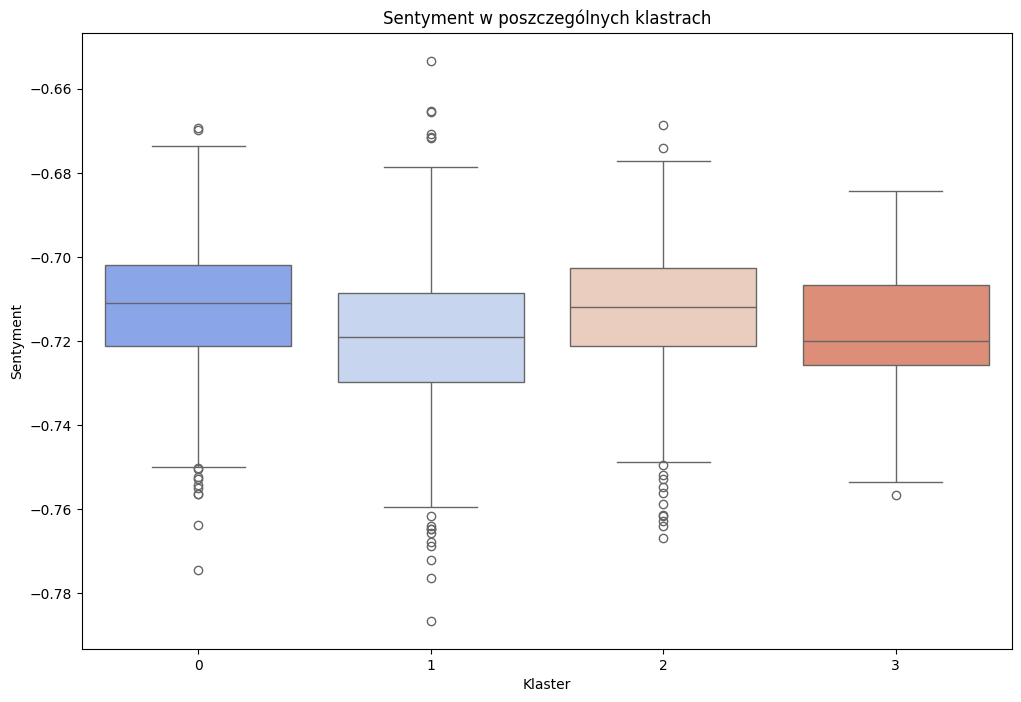

In [20]:
plt.figure(figsize=(12, 8))
sns.boxplot(data=df, x='cluster', y='sentiment', palette='coolwarm')
plt.title('Sentyment w poszczególnych klastrach')
plt.xlabel('Klaster')
plt.ylabel('Sentyment')
plt.show()

### Zapis wygenerowanych danych

In [22]:
# Zapisywanie DataFrame do Excela, wraz z sentymentem i klastrem
df.to_excel('output_with_sentiment_and_clusters.xlsx', index=False)

Następnie, uzyskane dane naniesiono ręcznie na oczyszczony plik będący bazą do dalszej analizy.